<a href="https://colab.research.google.com/github/Jannyney/ImageCaptioning/blob/main/Image_Captioning_Thai_Updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2018 The TensorFlow Authors.


# Image captioning with visual attention



Given an image like the example below, your goal is to generate a caption such as "a surfer riding on a wave".

![Man Surfing](https://tensorflow.org/images/surf.jpg)

*[Image Source](https://commons.wikimedia.org/wiki/Surfing#/media/File:Surfing_in_Hawaii.jpg); License: Public Domain*

To accomplish this, you'll use an attention-based model, which enables us to see what parts of the image the model focuses on as it generates a caption.

![Prediction](https://tensorflow.org/images/imcap_prediction.png)

The model architecture is similar to [Show, Attend and Tell: Neural Image Caption Generation with Visual Attention](https://arxiv.org/abs/1502.03044).

This notebook is an end-to-end example. When you run the notebook, it downloads the [MS-COCO](http://cocodataset.org/#home) dataset, preprocesses and caches a subset of images using Inception V3, trains an encoder-decoder model, and generates captions on new images using the trained model.

In this example, you will train a model on a relatively small amount of data—the first 30,000 captions  for about 20,000 images (because there are multiple captions per image in the dataset).

In [1]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# your model focuses on during captioning
import matplotlib.pyplot as plt

import collections
import random
import numpy as np
import os
import time
import json
from PIL import Image

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Kaggle"

In [4]:
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"

## Download file from Kaggle
https://www.kaggle.com/general/74235

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jirapongpansak","key":"5b49087592f6b1cb16b3ef339c217d52"}'}

In [ ]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              229KB  2021-06-12 15:32:48           7379  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           4468  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           1512  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   1GB  2021-06-09 15:58:24           2208  
fatiimaezzahra/famous-iconic-women                          Famous Iconic Wo

In [ ]:
!kaggle datasets download -d adityajn105/flickr8k

100% 1.03G/1.04G [00:08<00:00, 170MB/s]
100% 1.04G/1.04G [00:08<00:00, 133MB/s]


In [ ]:
! mkdir train

In [ ]:
! unzip flickr8k.zip -d train

Streaming output truncated to the last 5000 lines.
  inflating: train/Images/2844846111_8c1cbfc75d.jpg  
  inflating: train/Images/2844963839_ff09cdb81f.jpg  
  inflating: train/Images/2845246160_d0d1bbd6f0.jpg  
  inflating: train/Images/2845691057_d4ab89d889.jpg  
  inflating: train/Images/2845845721_d0bc113ff7.jpg  
  inflating: train/Images/2846037553_1a1de50709.jpg  
  inflating: train/Images/2846785268_904c5fcf9f.jpg  
  inflating: train/Images/2846843520_b0e6211478.jpg  
  inflating: train/Images/2847514745_9a35493023.jpg  
  inflating: train/Images/2847615962_c330bded6e.jpg  
  inflating: train/Images/2847859796_4d9cb0d31f.jpg  
  inflating: train/Images/2848266893_9693c66275.jpg  
  inflating: train/Images/2848571082_26454cb981.jpg  
  inflating: train/Images/2848895544_6d06210e9d.jpg  
  inflating: train/Images/2848977044_446a31d86e.jpg  
  inflating: train/Images/2849194983_2968c72832.jpg  
  inflating: train/Images/2850719435_221f15e951.jpg  
  inflating: train/Images/28511

## Optional: limit the size of the training set 
To speed up training for this tutorial, you'll use a subset of 30,000 captions and their corresponding images to train your model. Choosing to use more data would result in improved captioning quality.

In [6]:
image_folder = '/gdrive/MyDrive/Kaggle/train/Images/'
PATH = os.path.abspath('.') + image_folder

In [7]:
annotation_file = '/content/gdrive/MyDrive/Kaggle/train/caption_th.txt'

In [8]:
import pandas as pd
import csv
import glob

In [9]:
with open(annotation_file, 'r') as f:
    next(f)
    annotations = csv.reader(f)
    annotations = pd.DataFrame(annotations, columns=['image','caption_th'])

In [10]:
len(annotations)

40455

In [11]:
annotations.head(n=10)

,image,caption_th
0,1000268201_693b08cb0e.jpg,เด็กในชุดสีชมพูกําลังปีนขึ้นบันไดในทางเข้า
1,1000268201_693b08cb0e.jpg,เด็กผู้หญิงกําลังเข้าไปในตึกไม้
2,1000268201_693b08cb0e.jpg,เด็กผู้หญิงกําลังปีนเข้าไปในบ้านเด็กเล่น
3,1000268201_693b08cb0e.jpg,เด็กหญิงตัวเล็ก ๆ ปีนบันไดไปที่หอละครของเธอ
4,1000268201_693b08cb0e.jpg,เด็กผู้หญิงในชุดสีชมพู เข้าไปในกระท่อมไม้
5,1001773457_577c3a7d70.jpg,สุนัขสีดําและสุนัขลายจุดกําลังต่อสู้
6,1001773457_577c3a7d70.jpg,สุนัขผิวดําและสุนัขตัวร้ายที่เล่นกันบนถนน
7,1001773457_577c3a7d70.jpg,สุนัขสีดําและสุนัขสีขาวที่มีจุดสีน้ําตาลกําลัง...
8,1001773457_577c3a7d70.jpg,สุนัขสองตัวที่มีสายพันธุ์ที่แตกต่างกันมองกันบนถนน
9,1001773457_577c3a7d70.jpg,สุนัขสองตัวบนทางเท้าเคลื่อนที่เข้าหากัน


In [12]:
# Group all captions together having the same image ID.
image_path_to_caption = collections.defaultdict(list)
for val in zip(annotations['image'],annotations['caption_th']):
  #caption = f"<start> {val[1]} <end>"
  caption = f"{val[1]}"
  #image_path = PATH + 'images_' + '%012d.jpg' % (val[0])
  image_path = "{}{}".format(PATH,val[0])
  image_path_to_caption[image_path].append(caption)

In [13]:
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)

# Select the first 6000 image_paths from the shuffled set.
# Approximately each image id has 5 captions associated with it, so that will
# lead to 30,000 examples.
train_image_paths = image_paths[:6000]
print(len(train_image_paths))

6000


In [14]:
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))

นักมวยในกางเกงสีดําจะชิงช้าที่นักมวยในกางเกงสีขาว


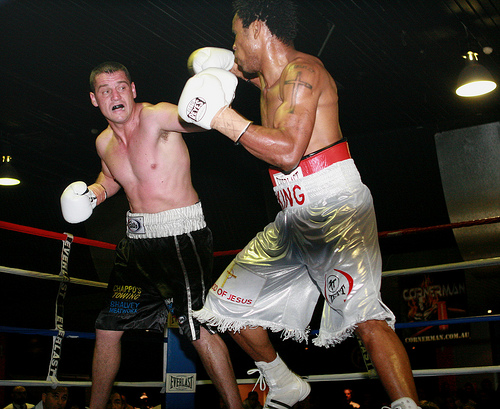

In [15]:
print(train_captions[0])
Image.open(img_name_vector[0])

## Preprocess the images using InceptionV3
Next, you will use InceptionV3 (which is pretrained on Imagenet) to classify each image. You will extract features from the last convolutional layer.

First, you will convert the images into InceptionV3's expected format by:
* Resizing the image to 299px by 299px
* [Preprocess the images](https://cloud.google.com/tpu/docs/inception-v3-advanced#preprocessing_stage) using the [preprocess_input](https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_v3/preprocess_input) method to normalize the image so that it contains pixels in the range of -1 to 1, which matches the format of the images used to train InceptionV3.

In [16]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

## Initialize InceptionV3 and load the pretrained Imagenet weights

Now you'll create a tf.keras model where the output layer is the last convolutional layer in the InceptionV3 architecture. The shape of the output of this layer is ```8x8x2048```. You use the last convolutional layer because you are using attention in this example. You don't perform this initialization during training because it could become a bottleneck.

* You forward each image through the network and store the resulting vector in a dictionary (image_name --> feature_vector).
* After all the images are passed through the network, you save the dictionary to disk.


In [17]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87916544/87910968 [==============================] - 2s 0us/step


## Caching the features extracted from InceptionV3

You will pre-process each image with InceptionV3 and cache the output to disk. Caching the output in RAM would be faster but also memory intensive, requiring 8 \* 8 \* 2048 floats per image. At the time of writing, this exceeds the memory limitations of Colab (currently 12GB of memory).

Performance could be improved with a more sophisticated caching strategy (for example, by sharding the images to reduce random access disk I/O), but that would require more code.

The caching will take about 10 minutes to run in Colab with a GPU. If you'd like to see a progress bar, you can: 

1. Install [tqdm](https://github.com/tqdm/tqdm):

    `!pip install tqdm`

2. Import tqdm:

    `from tqdm import tqdm`

3. Change the following line:

    `for img, path in image_dataset:`

    to:

    `for img, path in tqdm(image_dataset):`


In [18]:
!pip install tqdm

In [19]:
from tqdm import tqdm
# Get unique images
encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

100%|██████████| 375/375 [43:56<00:00,  7.03s/it]


## Preprocess and tokenize the captions

* First, you'll tokenize the captions (for example, by splitting on spaces). This gives us a  vocabulary of all of the unique words in the data (for example, "surfing", "football", and so on).
* Next, you'll limit the vocabulary size to the top 5,000 words (to save memory). You'll replace all other words with the token "UNK" (unknown).
* You then create word-to-index and index-to-word mappings.
* Finally, you pad all sequences to be the same length as the longest one.

In [20]:
!pip install pythainlp
!pip install stop_words
import pythainlp
from pythainlp import word_tokenize
#from pythainlp.corpus import stopwords
from pythainlp.corpus import wordnet
from nltk.stem.porter import PorterStemmer
from nltk.corpus import words
from stop_words import get_stop_words

     |████████████████████████████████| 11.0MB 12.4MB/s 
     |████████████████████████████████| 747kB 35.8MB/s 
  Created wheel for stop-words: filename=stop_words-2018.7.23-cp37-none-any.whl size=32913 sha256=720585b46b87f688cb37c06ff30058ab94832dff1bf3a2f806181794569cf01e
  Stored in directory: /root/.cache/pip/wheels/75/37/6a/2b295e03bd07290f0da95c3adb9a74ba95fbc333aa8b0c7c78
Successfully built stop-words
[nltk_data] Downloading package omw to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [21]:
from pythainlp.corpus import thai_stopwords

In [22]:
print(type(train_captions))
print(len(train_captions))

<class 'list'>
30000


### Tokenize word

In [23]:
!pip install pythainlp[attacut]

     |████████████████████████████████| 1.3MB 14.5MB/s 
     |████████████████████████████████| 481kB 35.5MB/s 
     |████████████████████████████████| 645kB 39.1MB/s 
     |████████████████████████████████| 92kB 10.3MB/s 
     |████████████████████████████████| 51kB 6.5MB/s 
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115943 sha256=3bc57df1851e07c6842a9c7d9e7894a727c6d1dc2d53c3a8bf0f103a66cf393f
  Stored in directory: /root/.cache/pip/wheels/af/19/30/1ea0cad502dcb4e66ed5a690279628c827aea38bbbab75d5ed
Successfully built fire
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [24]:
from pythainlp.tokenize import word_tokenize 
from collections import Counter, OrderedDict
import itertools

In [25]:
print(type(train_captions))

<class 'list'>


In [26]:
print(train_captions[0])

นักมวยในกางเกงสีดําจะชิงช้าที่นักมวยในกางเกงสีขาว


In [27]:
import re
for i in range(len(train_captions)):
    train_captions[i] = re.sub(r',','', train_captions[i])  #remove comma

In [28]:
imgs = []
thai_texts = []

for line in train_captions:
  img = line.split(',')[0]
  thai_text = line.split(',')[-1].replace('\n','')

  imgs.append(img)
  thai_texts.append(thai_text)

In [29]:
thai_text_tokenizes = []

for i,thai_text in enumerate(thai_texts):
  thai_text_tokenizes.append(word_tokenize(thai_text,engine='newmm'))
  print(f"{i}/{len(thai_texts)}", end='\r')

In [30]:
thai_text_tokenizes_merge = list(itertools.chain(*thai_text_tokenizes))
thai_counter = Counter(thai_text_tokenizes_merge)

In [31]:
thai_vocab_index_to_word = {0:'<start>', 1:'<end>'}
thai_vocab_word_to_index = {'<start>':0, '<end>':1}

for i, word in enumerate(thai_counter):
  thai_vocab_index_to_word[i+2] = word
  thai_vocab_word_to_index[word] = i+2

In [32]:
thai_vocab_index_to_word

{0: '<start>',
 1: '<end>',
 2: 'นักมวย',
 3: 'ใน',
 4: 'กางเกง',
 5: 'สีด',
 6: 'ํา',
 7: 'จะ',
 8: 'ชิงช้า',
 9: 'ที่',
 10: 'สี',
 11: 'ขาว',
 12: 'ชาย',
 13: 'ใส่',
 14: 'กางเกงขาสั้น',
 15: ' ',
 16: 'ชกมวย',
 17: 'และ',
 18: 'สวม',
 19: 'มวย',
 20: 'ดํา',
 21: 'ถุงมือ',
 22: 'สอง',
 23: 'คน',
 24: 'สู้',
 25: 'กัน',
 26: 'วงแหวน',
 27: 'ล้อมรอบ',
 28: 'ด้วย',
 29: 'ที่นั่ง',
 30: 'ของ',
 31: 'มัน',
 32: 'การ',
 33: 'แข่ง',
 34: 'กับ',
 35: 'ถุง',
 36: 'มือสี',
 37: 'เด็กผู้ชาย',
 38: 'กระโดด',
 39: 'ข้าม',
 40: 'น้ํา',
 41: 'ว่าย',
 42: 'สปริง',
 43: 'เก',
 44: 'อร',
 45: '์',
 46: 'สวน',
 47: 'หลังบ้าน',
 48: 'เด็กชาย',
 49: 'แว่นตา',
 50: 'ลง',
 51: 'ไป',
 52: 'สเปรย์',
 53: 'ผ่าน',
 54: 'หมอก',
 55: 'มี',
 56: 'เล่น',
 57: 'อยู่',
 58: 'เด็ก',
 59: 'สาม',
 60: 'คนใน',
 61: 'ทุ่ง',
 62: 'ดอกไม้',
 63: 'นึง',
 64: 'มีลูก',
 65: 'แมว',
 66: 'ยัดไส้',
 67: 'โพส',
 68: 'ท่ามกลาง',
 69: 'ป่า',
 70: 'กํา',
 71: 'ลัง',
 72: 'ของเล่น',
 73: 'ฝูง',
 74: 'ชนก',
 75: 'มอง',
 76: 'สุนัข',


In [33]:
print(len(thai_vocab_index_to_word.keys()))

6139


In [34]:
def convert_sentence_to_index_token(sentence: str):
  word_in_sentence = ['<start>']+ word_tokenize(sentence, engine='newmm') + ['<end>']
  word_index = [thai_vocab_word_to_index[word] for word in word_in_sentence]
  return word_in_sentence, word_index

In [35]:
word_in_sentence, word_index = convert_sentence_to_index_token(train_captions[1])

In [36]:
for i, word in enumerate(word_in_sentence):
  print(word, word_index[i])

<start> 0
ชาย 12
ใส่ 13
กางเกงขาสั้น 14
สีด 5
ํา 6
  15
ชกมวย 16
  15
และ 17
ชาย 12
ใส่ 13
กางเกงขาสั้น 14
สี 10
ขาว 11
<end> 1


In [37]:
train_seqs = []
sentence_lis = []
for i in train_captions:
  word_in_sentence, word_index = convert_sentence_to_index_token(i)
  for j, word in enumerate(word_in_sentence):
    sentence_lis.append(word_index[j])
  train_seqs.append(sentence_lis)
  sentence_lis = []
print(train_seqs)

[[0, 2, 3, 4, 5, 6, 7, 8, 9, 2, 3, 4, 10, 11, 1], [0, 12, 13, 14, 5, 6, 15, 16, 15, 17, 12, 13, 14, 10, 11, 1], [0, 12, 18, 14, 19, 20, 15, 21, 19, 11, 15, 17, 12, 18, 14, 19, 11, 15, 18, 21, 19, 11, 1], [0, 2, 22, 23, 24, 25, 3, 26, 9, 27, 28, 29, 30, 2, 1], [0, 12, 22, 23, 24, 31, 3, 32, 33, 19, 34, 35, 36, 11, 1], [0, 37, 38, 39, 40, 1], [0, 37, 13, 4, 41, 40, 38, 39, 40, 42, 43, 44, 45, 3, 46, 47, 1], [0, 48, 3, 49, 38, 50, 51, 3, 52, 40, 1], [0, 48, 38, 53, 54, 40, 1], [0, 37, 9, 55, 49, 56, 57, 3, 42, 43, 44, 45, 1], [0, 58, 59, 60, 61, 9, 55, 62, 10, 11, 1], [0, 58, 59, 23, 15, 23, 63, 64, 65, 66, 15, 57, 3, 61, 62, 1], [0, 58, 59, 23, 56, 3, 46, 1], [0, 59, 58, 67, 68, 62, 69, 1], [0, 58, 59, 23, 70, 71, 56, 57, 34, 65, 72, 3, 46, 1], [0, 73, 74, 6, 71, 75, 76, 77, 78, 79, 1], [0, 76, 70, 71, 80, 53, 81, 15, 82, 83, 84, 85, 1], [0, 76, 20, 86, 32, 87, 88, 79, 82, 89, 90, 91, 30, 92, 1], [0, 76, 10, 40, 93, 94, 95, 96, 78, 79, 10, 40, 97, 1], [0, 98, 99, 100, 101, 102, 15, 77, 3

In [73]:
print(len(train_seqs))

30000


In [39]:
# Find the maximum length of any caption in the dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [40]:
# Choose the top 5000 words from the vocabulary
top_k = len(thai_vocab_index_to_word.keys())
#top_k = 5000

In [41]:
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')
print(cap_vector)

[[   0    2    3 ...    0    0    0]
 [   0   12   13 ...    0    0    0]
 [   0   12   18 ...    0    0    0]
 ...
 [   0  372  121 ...    0    0    0]
 [   0  172   13 ...    0    0    0]
 [   0  372 1347 ...    0    0    0]]


In [42]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)
print(max_length)

43


## Split the data into training and testing

In [43]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

In [44]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(24000, 24000, 6000, 6000)

## Create a tf.data dataset for training


Your images and captions are ready! Next, let's create a `tf.data` dataset to use for training your model.

In [45]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [46]:
print(vocab_size)

6140


In [47]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [48]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

## Model

Fun fact: the decoder below is identical to the one in the example for [Neural Machine Translation with Attention](../sequences/nmt_with_attention.ipynb).

The model architecture is inspired by the [Show, Attend and Tell](https://arxiv.org/pdf/1502.03044.pdf) paper.

* In this example, you extract the features from the lower convolutional layer of InceptionV3 giving us a vector of shape (8, 8, 2048).
* You squash that to a shape of (64, 2048).
* This vector is then passed through the CNN Encoder (which consists of a single Fully connected layer).
* The RNN (here GRU) attends over the image to predict the next word.

In [49]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [50]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [51]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [52]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [53]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Checkpoint

In [54]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [55]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

## Training

* You extract the features stored in the respective `.npy` files and then pass those features through the encoder.
* The encoder output, hidden state(initialized to 0) and the decoder input (which is the start token) is passed to the decoder.
* The decoder returns the predictions and the decoder hidden state.
* The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
* Use teacher forcing to decide the next input to the decoder.
* Teacher forcing is the technique where the target word is passed as the next input to the decoder.
* The final step is to calculate the gradients and apply it to the optimizer and backpropagate.


In [56]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [57]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([thai_vocab_word_to_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [58]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 2.3130
Epoch 1 Batch 100 Loss 1.2409
Epoch 1 Batch 200 Loss 1.2030
Epoch 1 Batch 300 Loss 1.0584
Epoch 1 Loss 1.268456
Time taken for 1 epoch 221.78 sec

Epoch 2 Batch 0 Loss 1.0264
Epoch 2 Batch 100 Loss 0.9491
Epoch 2 Batch 200 Loss 0.8178
Epoch 2 Batch 300 Loss 0.9375
Epoch 2 Loss 0.941940
Time taken for 1 epoch 158.30 sec

Epoch 3 Batch 0 Loss 0.8800
Epoch 3 Batch 100 Loss 0.7454
Epoch 3 Batch 200 Loss 0.7870
Epoch 3 Batch 300 Loss 0.8411
Epoch 3 Loss 0.842516
Time taken for 1 epoch 157.99 sec

Epoch 4 Batch 0 Loss 0.8657
Epoch 4 Batch 100 Loss 0.7493
Epoch 4 Batch 200 Loss 0.8111
Epoch 4 Batch 300 Loss 0.7182
Epoch 4 Loss 0.776792
Time taken for 1 epoch 158.00 sec

Epoch 5 Batch 0 Loss 0.8203
Epoch 5 Batch 100 Loss 0.7592
Epoch 5 Batch 200 Loss 0.7345
Epoch 5 Batch 300 Loss 0.7457
Epoch 5 Loss 0.725734
Time taken for 1 epoch 158.09 sec

Epoch 6 Batch 0 Loss 0.7553
Epoch 6 Batch 100 Loss 0.7105
Epoch 6 Batch 200 Loss 0.7237
Epoch 6 Batch 300 Loss 0.7518
Epoch 6

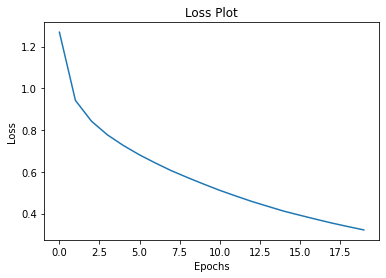

In [59]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Caption!

* The evaluate function is similar to the training loop, except you don't use teacher forcing here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the end token.
* And store the attention weights for every time step.

In [69]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([thai_vocab_word_to_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(thai_vocab_index_to_word[predicted_id])

        if thai_vocab_index_to_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [70]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(np.ceil(len_result/2), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

In [74]:
!wget -q https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf

In [75]:
# !pip install -U --pre matplotlib  
import matplotlib as mpl
mpl.font_manager.fontManager.addfont('thsarabunnew-webfont.ttf')
mpl.rc('font', family='TH Sarabun New')

In [76]:
!wget -q http://www.arts.chula.ac.th/ling/wp-content/uploads/TH-Sarabun_Chula1.1.zip -O font.zip
!unzip -qj font.zip TH-Sarabun_Chula1.1/THSarabunChula-Regular.ttf

In [78]:
# !pip install -U --pre matplotlib  
import matplotlib as mpl
mpl.font_manager.fontManager.addfont('THSarabunChula-Regular.ttf')
mpl.rc('font', family='TH Sarabun Chula')

Real Caption: ทาร กก ํา ลัง อาบ น้ํา ใน ชาม ที่ เต็มไปด้วย น้ํา <end>
Prediction Caption: เด็ก กํา ลัง นั่ง อยู่ บน อยู่ ใน อ่าง ของ เขา <end>


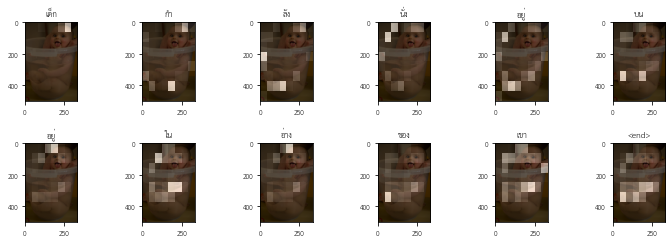

In [79]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([thai_vocab_index_to_word[i]
                        for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

## Try it on your own images

For fun, below you're provided a method you can use to caption your own images with the model you've just trained. Keep in mind, it was trained on a relatively small amount of data, and your images may be different from the training data (so be prepared for weird results!)


Prediction Caption: มนุษย์ กํา ลัง เล่น กระดานโต้คลื่น <end>


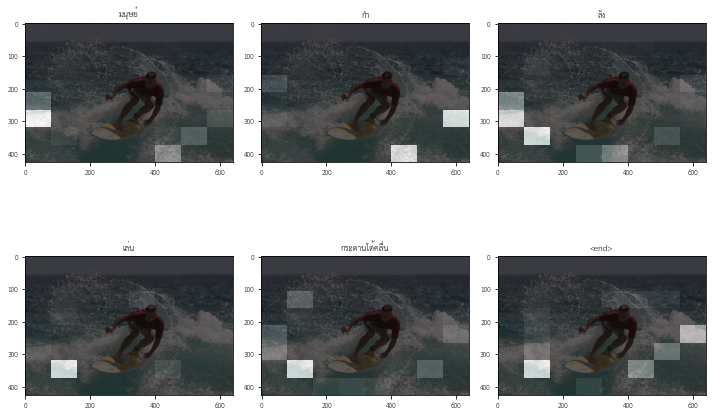

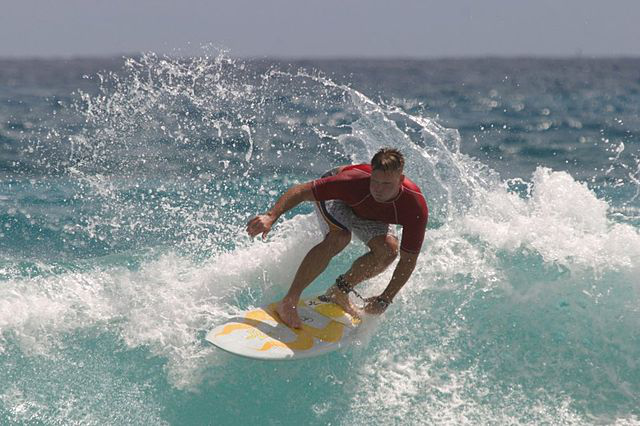

In [86]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension, origin=image_url)

result, attention_plot = evaluate(image_path)
print('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

# Next steps

Congrats! You've just trained an image captioning model with attention. Next, take a look at this example [Neural Machine Translation with Attention](../sequences/nmt_with_attention.ipynb). It uses a similar architecture to translate between Spanish and English sentences. You can also experiment with training the code in this notebook on a different dataset.